In [1]:
!kaggle datasets download -d ikramali585/emergency-vs-non-emergency-vehicles

Dataset URL: https://www.kaggle.com/datasets/ikramali585/emergency-vs-non-emergency-vehicles
License(s): MIT
 99% 224M/227M [00:08<00:00, 26.4MB/s]
100% 227M/227M [00:08<00:00, 27.3MB/s]


In [2]:
!unzip 'emergency-vs-non-emergency-vehicles.zip' -d 'dataset'

Archive:  emergency-vs-non-emergency-vehicles.zip
  inflating: dataset/classes.txt     
  inflating: dataset/data.yaml       
  inflating: dataset/train/images/ambulances Pakistan_100.png  
  inflating: dataset/train/images/ambulances Pakistan_101.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_103.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_104.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_105.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_106.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_107.png  
  inflating: dataset/train/images/ambulances Pakistan_108.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_109.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_110.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_112.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_117.jpeg  
  inflating: dataset/train/images/ambulances Pakistan_118.jpeg  
  inflating: dataset/train/imag

In [2]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np
np.random.seed(42)

In [3]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 10

### Visualize a Few Ground Truth Images


In [4]:
class_names = ['emergency_vehicle',"non_emergency_vehicle"]
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [5]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [6]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [7]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

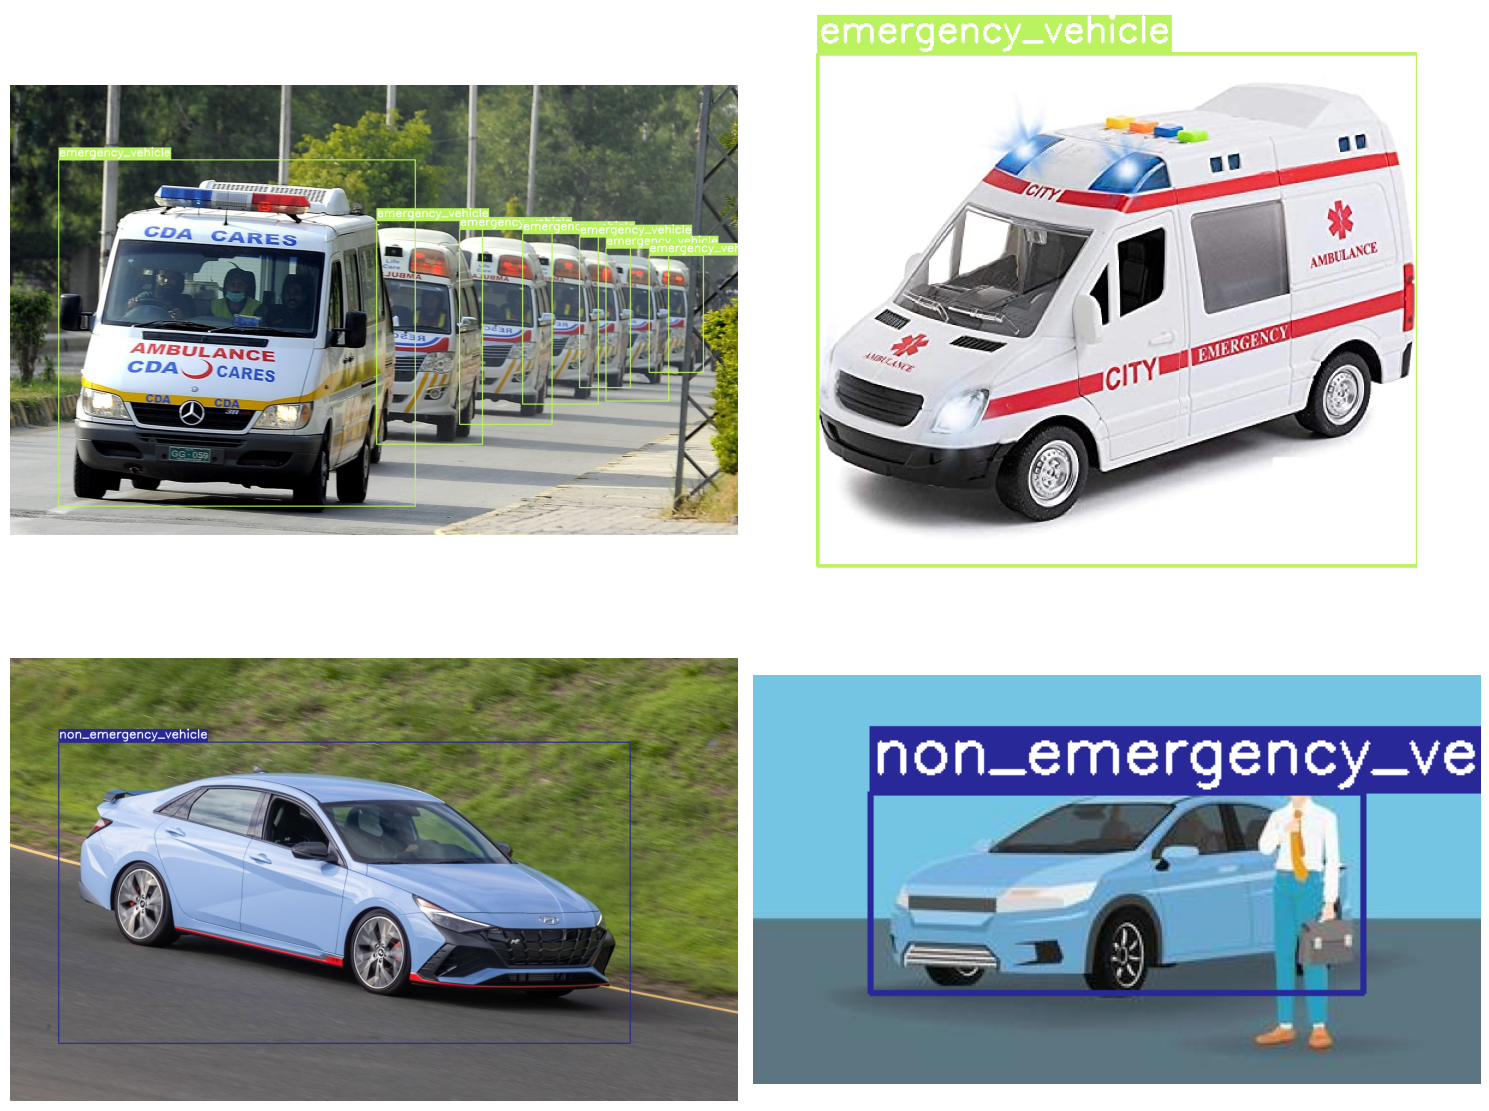

In [8]:
# Visualize a few training images.
plot(
    image_paths='dataset/train/images/*',
    label_paths='dataset/train/labels/*',
    num_samples=4,
)

## Helper Functions for Logging


In [9]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

## Clone YOLOV5 Repository

In [10]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [11]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [12]:
!pip install -r requirements.txt

## Training using YOLOV5

In [18]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data '/content/dataset/data.yaml' --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 64 --name {RES_DIR}

Current number of result directories: 1
results_2
2024-07-03 09:18:17.056037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 09:18:17.056090: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 09:18:17.057511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/dataset/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=64, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image

### Visualization and Inference Utilities

In [19]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [20]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

We may also need to visualize images in any of the directories. The following function accepts a directory path and plots all the images in them.

In [21]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

confusion_matrix.png				    P_curve.png       train_batch2.jpg
events.out.tfevents.1719998299.2de3296f3d39.2054.0  PR_curve.png      val_batch0_labels.jpg
F1_curve.png					    R_curve.png       val_batch0_pred.jpg
hyp.yaml					    results.csv       val_batch1_labels.jpg
labels_correlogram.jpg				    results.png       val_batch1_pred.jpg
labels.jpg					    train_batch0.jpg  weights
opt.yaml					    train_batch1.jpg
['runs/train/results_2/val_batch0_pred.jpg', 'runs/train/results_2/val_batch1_pred.jpg']


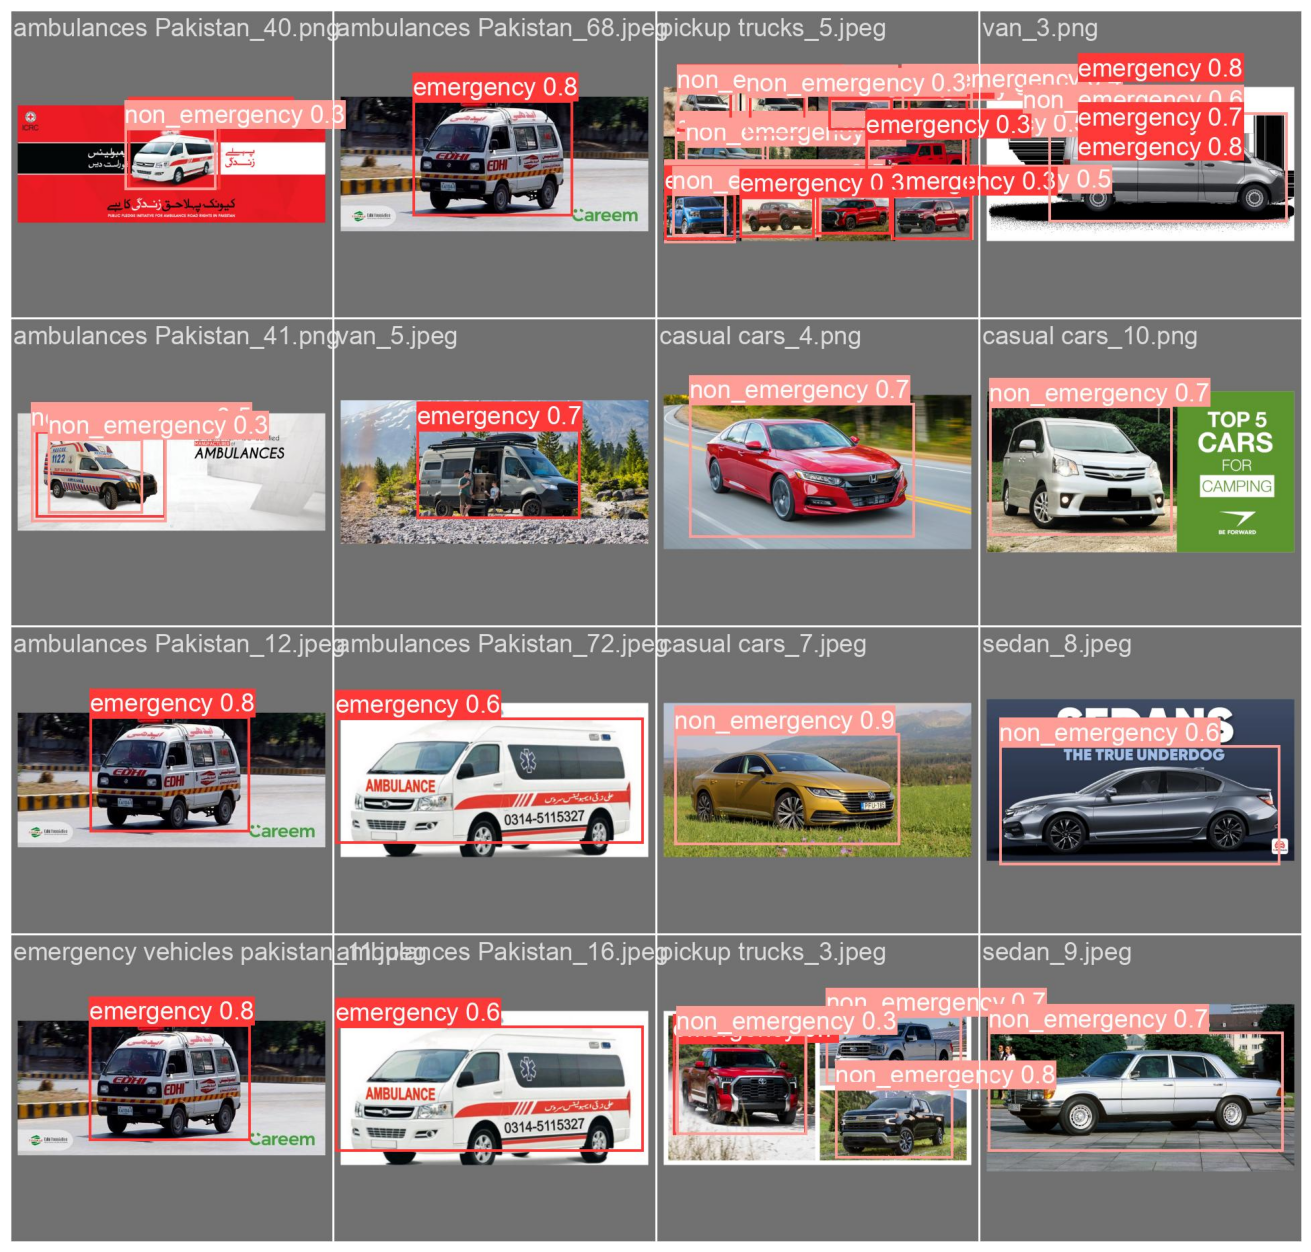

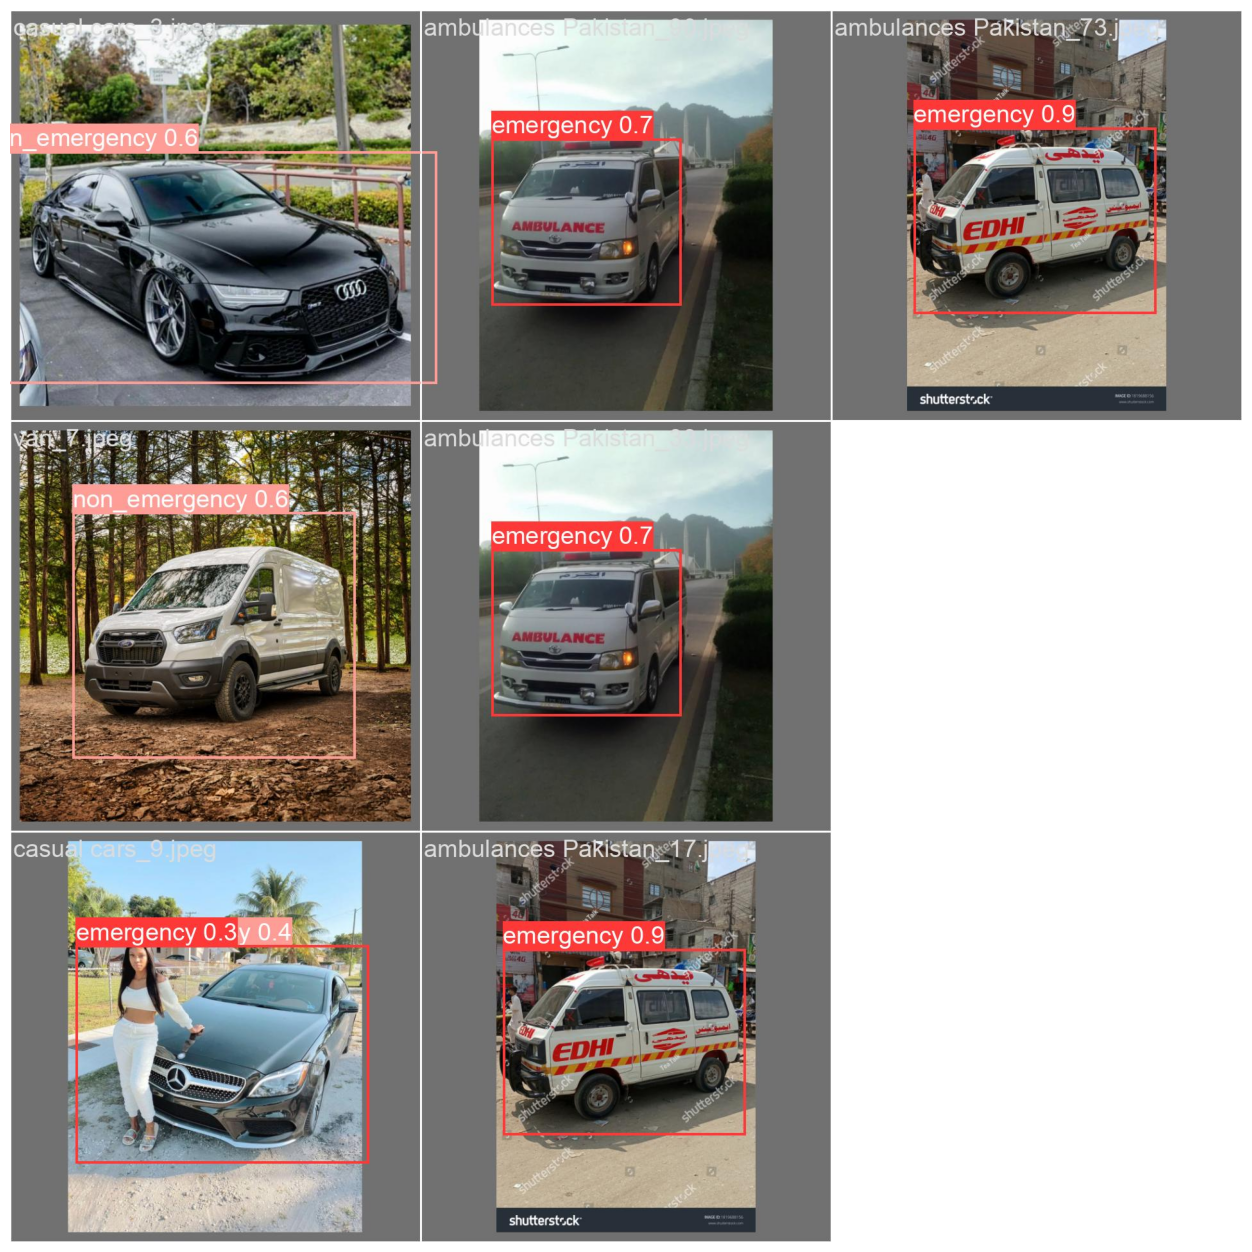

In [22]:
show_valid_results(RES_DIR)